# Natural Langage Processing : Matrice TF-IDF et similarité cosinus

On va reprendre dans ce notebook l'article [suivant](https://janav.wordpress.com/2013/10/27/tf-idf-and-cosine-similarity/). L'objectif est de trouver une mesure de la similarité entre 2 textes. Par exemple, une requête google et un site.

On considère l'ensemble de documents contenant les 3 phrases et la requête ci-dessous.

In [1]:
import pandas as pd
df = pd.DataFrame(["The game of life is a game of everlasting learning",
                   "The unexamined life is not worth living",
                   "Never stop learning"],
                  columns=['texte'])
df

,texte
0,The game of life is a game of everlasting lear...
1,The unexamined life is not worth living
2,Never stop learning


In [2]:
df_requete = pd.DataFrame(["life learning"], columns=['texte'])
df_requete

,texte
0,life learning


## 1. Term Frequency (TF)

C'est tout simplement la fréquence de chaque mot dans chaque document. On peut le faire à la main relativement simplement mais on va pas le faire...

In [3]:
# avec sklearn
from sklearn.feature_extraction.text import CountVectorizer
countVec = CountVectorizer(token_pattern='(?u)\\b\\w+\\b')
df_tf = countVec.fit_transform(df.texte)
df_tf = pd.DataFrame(df_tf.toarray(),
                     columns=countVec.get_feature_names_out())
df_tf

,a,everlasting,game,is,learning,life,living,never,not,of,stop,the,unexamined,worth
0,1,1,2,1,1,1,0,0,0,2,0,1,0,0
1,0,0,0,1,0,1,1,0,1,0,0,1,1,1
2,0,0,0,0,1,0,0,1,0,0,1,0,0,0


Le problème c'est que selon la taille du document, le nombre d'occurences n'a pas du tout le même sens...une solution peut être de normaliser en divisant par la taille du document.

In [4]:
# TF normalisé
df_tf_norm = df_tf.copy().astype(float)
for i in range(3):
    df_tf_norm.loc[i] = df_tf.loc[i]/len(df.loc[i,'texte'].split())
df_tf_norm

,a,everlasting,game,is,learning,life,living,never,not,of,stop,the,unexamined,worth
0,0.1,0.1,0.2,0.100000,0.100000,0.100000,0.000000,0.000000,0.000000,0.2,0.000000,0.100000,0.000000,0.000000
1,0.0,0.0,0.0,0.142857,0.000000,0.142857,0.142857,0.000000,0.142857,0.0,0.000000,0.142857,0.142857,0.142857
2,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.0,0.333333,0.000000,0.000000,0.000000


In [5]:
# petite astuce au passage la méthode .div
df_tf_norm = df_tf.div(df_tf.sum(axis=1), axis=0)
df_tf_norm

,a,everlasting,game,is,learning,life,living,never,not,of,stop,the,unexamined,worth
0,0.1,0.1,0.2,0.100000,0.100000,0.100000,0.000000,0.000000,0.000000,0.2,0.000000,0.100000,0.000000,0.000000
1,0.0,0.0,0.0,0.142857,0.000000,0.142857,0.142857,0.000000,0.142857,0.0,0.000000,0.142857,0.142857,0.142857
2,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.0,0.333333,0.000000,0.000000,0.000000


Le problème c'est qu'on considère tous les mots comme ayant la même importance. Notamment, des mots ayant une trop grande fréquence (c'est-à-dire présents dans beaucoup de documents) ne sont pas pertinents pour mesurer la similarité. Une solution ça va être d'utiliser une mesure qui décroit avec le nombre de documents dans lequel le mot est présent.

## Inverse Document Frequency

Cette mesure va permettre de :
- **baisser** l'importance d'un terme s'il est trop présent
- **augmenter**  l'importance d'un terme rare

$$IDF_{mot} = \log(\frac{N}{n_{mot}})$$

avec $N$ le nombre total de documents, $n_{mot}$ le nombre de documents contenant au moins une fois le terme $mot$

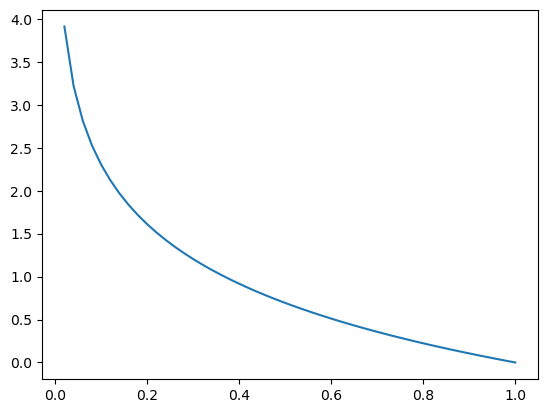

In [6]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0,1,51)
plt.plot(x[1:], list(map(lambda a: np.log(1/a), x[1:])));

In [7]:
def calcul_idf(mot):
    n = sum(df_tf[mot]>0)
    return 1 + np.log(3/n)

for mot in df_tf.columns:
    print(f"{mot} : {calcul_idf(mot)}")

a : 2.09861228866811
everlasting : 2.09861228866811
game : 2.09861228866811
is : 1.4054651081081644
learning : 1.4054651081081644
life : 1.4054651081081644
living : 2.09861228866811
never : 2.09861228866811
not : 2.09861228866811
of : 2.09861228866811
stop : 2.09861228866811
the : 1.4054651081081644
unexamined : 2.09861228866811
worth : 2.09861228866811


Finalement, maintenant qu'on a une mesure (TF) de la fréquence de mots qui augmente par définition si le terme est présent dans un document et une seconde mesure (IDF) qui attribue un poids à ce terme selon sa fréquence dans tous les documents. On plus qu'à les combiner !

## 3. TF-IDF

On fait juste $$TF\_IDF_{mot, doc} = TF_{mot, doc} * IDF_{mot}$$

In [8]:
df_tfidf = df_tf_norm.copy()

for mot in df_tf.columns:
    df_tfidf[mot] = df_tfidf[mot] * calcul_idf(mot)

df_tfidf

,a,everlasting,game,is,learning,life,living,never,not,of,stop,the,unexamined,worth
0,0.209861,0.209861,0.419722,0.140547,0.140547,0.140547,0.000000,0.000000,0.000000,0.419722,0.000000,0.140547,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.200781,0.000000,0.200781,0.299802,0.000000,0.299802,0.000000,0.000000,0.200781,0.299802,0.299802
2,0.000000,0.000000,0.000000,0.000000,0.468488,0.000000,0.000000,0.699537,0.000000,0.000000,0.699537,0.000000,0.000000,0.000000


In [9]:
# avec sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')
df_tfidf2 = tfidf.fit_transform(df.texte)
df_tfidf2 = pd.DataFrame(df_tfidf2.toarray(),
                         columns=countVec.get_feature_names_out())
df_tfidf2

,a,everlasting,game,is,learning,life,living,never,not,of,stop,the,unexamined,worth
0,0.284975,0.284975,0.569951,0.216731,0.216731,0.216731,0.000000,0.000000,0.000000,0.569951,0.000000,0.216731,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.317570,0.000000,0.317570,0.417567,0.000000,0.417567,0.000000,0.000000,0.317570,0.417567,0.417567
2,0.000000,0.000000,0.000000,0.000000,0.473630,0.000000,0.000000,0.622766,0.000000,0.000000,0.622766,0.000000,0.000000,0.000000


Les résultats ne sont pas exactement les mêmes car le calcul de sklearn diffèrent un peu. En effet pour `sklearn` :
1. on utilise pour $TF$ les occurences **sans normaliser**
2. avec les paramètres par défaut, la valeur de $IDF$ est $1+\log(\frac{1+N}{1+n_{mot}})$
3. enfin on normalise par ligne (par document donc) de sorte que la somme soit égale à 1

In [10]:
# pour retomber sur les valeurs de sklearn "à la main"

# on définit le calcul de IDF tel qu'il est fait avec les paramètres par défaut dans TfidfTransformer
def calcul_idf_2(mot):
    n = sum(df_tf[mot]>0)
    return 1+np.log((1+3)/(1+n))

# on multiplie le TF non normalisé par le terme IDF obtenu
df_tfidf3 = df_tf.copy()
for mot in df_tf.columns:
    df_tfidf3[mot] = df_tfidf3[mot] * calcul_idf_2(mot)

# enfin on normalise chaque ligne avec la norme classique L2
df_tfidf3 = df_tfidf.div(np.sqrt((df_tfidf**2).sum(axis=1)), axis=0)
df_tfidf3

,a,everlasting,game,is,learning,life,living,never,not,of,stop,the,unexamined,worth
0,0.291185,0.291185,0.582369,0.195010,0.195010,0.195010,0.000000,0.00000,0.000000,0.582369,0.00000,0.195010,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.289662,0.000000,0.289662,0.432518,0.00000,0.432518,0.000000,0.00000,0.289662,0.432518,0.432518
2,0.000000,0.000000,0.000000,0.000000,0.427993,0.000000,0.000000,0.63907,0.000000,0.000000,0.63907,0.000000,0.000000,0.000000


On n'oublie pas que les termes qui nous intéressent sont ceux de la requête c'est à dire : "life" et "learning".

In [11]:
# termes de la requête
df_tfidf2[['life', 'learning']]

,life,learning
0,0.216731,0.216731
1,0.317570,0.000000
2,0.000000,0.473630


# Similarité cosinus

Comme on a que 2 mots dans la recherche, pour chaque document on obtient un vecteur de dimension 2. L'ensemble des documents peut donc être vu comme un ensemble de vecteurs en dimensions 2 où chaque axe correspondant à un des termes. On peut ainsi représenter ces vecteurs dans le plan de la manière suivante.

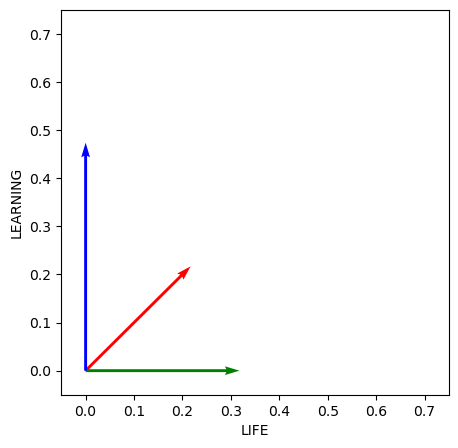

In [12]:
import matplotlib.pyplot as plt
origin = np.array([[0, 0, 0],[0, 0, 0]])
plt.figure(figsize=(5,5))
plt.quiver(*origin, df_tfidf2['life'], df_tfidf2['learning'],
           units='xy', angles='xy', scale_units='xy', scale=1,
           color=['r', 'g', 'b'])
plt.xlabel('LIFE')
plt.ylabel('LEARNING')
plt.xlim(-0.05,0.75)
plt.ylim(-0.05,0.75);

La similarité cosinus est une mesure qui dépend de l'angle entre les vecteurs et pas de leur longueur (ou amplitude). Ainsi on utilise souvent cette métrique pour les données textuelles car cela permet de s'affranchir du nombre d'occurences des mots (notamment pour des documents de longueurs différentes) tout en regardant l'importance relative des termes entre eux au sein du document.

On la calcule de la manière suivante. Pour 2 vecteurs $x$ et $y$ :

$$\frac{x.y}{\sqrt{x.x} \sqrt{y.y}} = \frac{x.y}{||x.x|| \times ||y.y||}$$

In [13]:
def sim_cos(x, y):
    return np.dot(x, y) / (np.sqrt(sum(x**2)) * np.sqrt(sum(y**2)))
#    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

On peut considérer la requete de l'utilisateur comme un "document" et donc calculer de la même manière que précédemment matrice TF-IDF pour la requête

In [14]:
# on fait la transformation avec sklearn en réutilisant directement le même objet
tfidf = TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')
df_req_tfidf = tfidf.fit_transform(df_requete.texte)
df_req_tfidf = pd.DataFrame(df_req_tfidf.toarray(),
                            columns=['life', 'learning'])
df_req_tfidf

,life,learning
0,0.707107,0.707107


On peut ainsi calculer la similarité cosinus entre la requête et chacun des documents de l'ensemble. La plus grande valeur traduit une plus grande proximité entre les 2.

In [15]:
for i in range(3):
    print(f"Similarité cosinus entre le document {i+1} et la requête : {sim_cos(df_req_tfidf.loc[0], df_tfidf2.loc[i,['life', 'learning']])}")

Similarité cosinus entre le document 1 et la requête : 1.0000000000000002
Similarité cosinus entre le document 2 et la requête : 0.7071067811865476
Similarité cosinus entre le document 3 et la requête : 0.7071067811865475


C'est donc bien dans le document 1 qui est le plus proche de notre requête (en l'occurrence c'est le seul contenant les 2 termes de la requête). On d'ailleurs bien le voir graphiquement.

In [16]:
df_plot = pd.concat((df_req_tfidf, df_tfidf2[['life', 'learning']]), axis=0)
df_plot.reset_index(drop=True, inplace=True)
df_plot

,life,learning
0,0.707107,0.707107
1,0.216731,0.216731
2,0.317570,0.000000
3,0.000000,0.473630


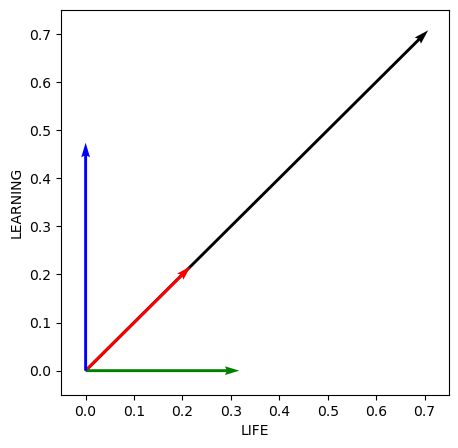

In [17]:
origin = np.array([[0, 0, 0, 0],[0, 0, 0, 0]])
plt.figure(figsize=(5,5))
plt.quiver(*origin, df_plot['life'], df_plot['learning'],
           units='xy', angles='xy', scale_units='xy', scale=1,
           color=['k', 'r', 'g', 'b'])
plt.xlabel('LIFE')
plt.ylabel('LEARNING')
plt.xlim(-0.05,0.75)
plt.ylim(-0.05,0.75);